In [ ]:
# !pip install git+https://github.com/d2cml-ai/csdid/
# !pip install git+https://github.com/d2cml-ai/DRDID

In [8]:
from csdid.att_gt import ATTgt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [13]:
dta = pd.read_csv("https://raw.githubusercontent.com/d2cml-ai/csdid/main/data/sim_data.csv")
dta

,G,X,id,cluster,period,Y,treat
0,3,-0.876233,1,5,1,5.562556,1
1,3,-0.876233,1,5,2,4.349213,1
2,3,-0.876233,1,5,3,7.134037,1
3,3,-0.876233,1,5,4,6.243056,1
4,2,-0.873848,2,36,1,-3.659387,1
...,...,...,...,...,...,...,...
15911,0,1.760185,4999,17,4,8.503466,0
15912,0,-2.313316,5000,40,1,-0.294177,0
15913,0,-2.313316,5000,40,2,-3.896103,0
15914,0,-2.313316,5000,40,3,-4.910720,0


In [3]:
import pandas as pd
from IPython.display import display, HTML

vc_id = dta["id"].value_counts().sort_index()
vc_cluster = dta["cluster"].value_counts().sort_index()
vc_g = dta["G"].value_counts().sort_index()
vc_period = dta["period"].value_counts().sort_index()
vc_treat = dta["treat"].value_counts().sort_index()

def shrink(series, head=5, tail=5):
    """Return first few lines, ..., last few lines."""
    items = list(series.items())
    if len(items) <= head + tail:
        rows = [f"{k}: {v}" for k, v in items]
    else:
        head_part = [f"{k}: {v}" for k, v in items[:head]]
        tail_part = [f"{k}: {v}" for k, v in items[-tail:]]
        rows = head_part + ["..."] + tail_part
    return rows

# Prepare columns
cols = {
    "id": shrink(vc_id),
    "cluster": shrink(vc_cluster),
    "G": [f"{k}: {v}" for k, v in vc_g.items()],
    "period": [f"{k}: {v}" for k, v in vc_period.items()],
    "treat": [f"{k}: {v}" for k, v in vc_treat.items()]
}

# Normalize lengths
max_len = max(len(v) for v in cols.values())
for k in cols:
    cols[k] += [""] * (max_len - len(cols[k]))

# Build HTML table
html = "<table style='border-collapse: collapse; font-family: monospace; font-size: 14px;'>"

# Header
html += "<tr>"
for col in cols.keys():
    html += f"<th style='padding: 6px 15px; border-bottom: 2px solid #555; text-align:left;'>{col}</th>"
html += "</tr>"

# Rows
for i in range(max_len):
    html += "<tr>"
    for col in cols.keys():
        html += f"<td style='padding: 4px 15px; border-bottom: 1px solid #ddd;'>{cols[col][i]}</td>"
    html += "</tr>"

html += "</table>"

display(HTML(html))

id,cluster,G,period,treat
1: 4,1: 236,0: 3980,1: 3979,0: 3980
2: 4,2: 312,2: 3924,2: 3979,1: 11936
4: 4,3: 308,3: 3900,3: 3979,
5: 4,4: 292,4: 4112,4: 3979,
6: 4,5: 380,,,
...,...,,,
4996: 4,46: 276,,,
4997: 4,47: 360,,,
4998: 4,48: 292,,,
4999: 4,49: 268,,,


- Balanced panel: $i=1,\dots,5000$, $t=1,\dots,4$
- 4 cohorts: treated at periods $2,3,4$ and never-treated $G=0$
- Treatment adopted at the <code>cluster</code> level

## (1) TWFE and Event Study 

### Two-way Fixed Effects

$$
y_{it} = \alpha_i + \lambda_t + \gamma^{TWFE} D_{it} + \varepsilon_{it}
$$


- $y_{it}$: outcome for unit $i$ at time $t$
- $\alpha_i$: **unit fixed effects**  
  These capture all time-invariant characteristics of unit $i$.
- $\lambda_t$: **time fixed effects**  
  These capture any shocks affecting all units in period $t$.
- $D_{it}$: **treatment indicator**  
  $$
  D_{it} =
  \begin{cases}
  0, & t < G_i,\\
  1, & t \ge G_i,
  \end{cases}
  $$
  Where $G_i$ is the period when unit $i$ begins treatment.  
  If $G_i = 0$ (never treated), then $D_{it} = 0$ for all $t$.



In [14]:
dta["D"] = (dta["period"] >= dta["G"]).astype(int)
dta.loc[dta["G"] == 0, "D"] = 0
dta

,G,X,id,cluster,period,Y,treat,D
0,3,-0.876233,1,5,1,5.562556,1,0
1,3,-0.876233,1,5,2,4.349213,1,0
2,3,-0.876233,1,5,3,7.134037,1,1
3,3,-0.876233,1,5,4,6.243056,1,1
4,2,-0.873848,2,36,1,-3.659387,1,0
...,...,...,...,...,...,...,...,...
15911,0,1.760185,4999,17,4,8.503466,0,0
15912,0,-2.313316,5000,40,1,-0.294177,0,0
15913,0,-2.313316,5000,40,2,-3.896103,0,0
15914,0,-2.313316,5000,40,3,-4.910720,0,0


In [25]:
# TWFE with control X 
model_twfe = smf.ols('Y ~ D + X + C(id) + C(period)', data=dta).fit()

coef_value = model_twfe.params['D']
se_value   = model_twfe.bse['D']
p_value    = model_twfe.pvalues['D']

print(f"TWFE Estimate (ATT): {coef_value:.3f}\nStandard Error: {se_value:.3f}\np-value: {p_value:.3f}")

TWFE Estimate (ATT): 1.330
Standard Error: 0.048
p-value: 0.000


### Event Study 

$$
y_{it} = \alpha_i + \lambda_t 
+ \sum_{k \neq -1} \gamma_k \, \mathbf{1}(t - G_i = k)
+ \varepsilon_{it}
$$

- $y_{it}$: outcome for unit $i$ at time $t$

- $\alpha_i$: **unit fixed effects**  
  These capture all time-invariant characteristics of unit $i$.

- $\lambda_t$: **time fixed effects**  
  These capture any shocks affecting all units in period $t$.

- $\mathbf{1}(t - G_i = k)$: **event-time indicators**  
  For each unit and time, this dummy equals 1 when the observation is $k$ periods away from its treatment date.  
  Event time is defined as  
  $$
  t - G_i.
  $$

- **Omitted category**: $k = -1$  
  This is the reference (baseline) period used for identification. All $\gamma_k$ coefficients are interpreted relative to the period **just before treatment**.

- Interpretation of coefficients:  
  - For $k < 0$: **pre-treatment leads**, used to check parallel trends.  
  - For $k > 0$: **post-treatment effects**, tracing the dynamic impact of treatment over time.

- Never-treated units ($G_i = 0$):  
  They never satisfy $t = G_i + k$, so all event-time indicators equal 0 for them.  
  They contribute to the estimation of $\alpha_i$ and $\lambda_t$, and serve as valid controls.

In [15]:
dta["t_rel"] = dta["period"] - dta["G"]
dta.loc[dta["G"] == 0, "t_rel"] = np.nan
dta["t_rel"].value_counts().sort_index()

t_rel
-3.0    1028
-2.0    2003
-1.0    2984
 0.0    2984
 1.0    1956
 2.0     981
Name: count, dtype: int64

In [16]:
for k in sorted(dta["t_rel"].dropna().unique()):
    
    if k < 0:
        name = f"D_m{abs(int(k))}"     # negative → D_m3, D_m2, ...
    else:
        name = f"D_{int(k)}"           # zero or positive → D_0, D_1, D_2, ...
    
    dta[name] = (dta["t_rel"] == k).astype(int)

dta

,G,X,id,cluster,period,Y,treat,D,t_rel,D_m3,D_m2,D_m1,D_0,D_1,D_2
0,3,-0.876233,1,5,1,5.562556,1,0,-2.0,0,1,0,0,0,0
1,3,-0.876233,1,5,2,4.349213,1,0,-1.0,0,0,1,0,0,0
2,3,-0.876233,1,5,3,7.134037,1,1,0.0,0,0,0,1,0,0
3,3,-0.876233,1,5,4,6.243056,1,1,1.0,0,0,0,0,1,0
4,2,-0.873848,2,36,1,-3.659387,1,0,-1.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15911,0,1.760185,4999,17,4,8.503466,0,0,NaN,0,0,0,0,0,0
15912,0,-2.313316,5000,40,1,-0.294177,0,0,NaN,0,0,0,0,0,0
15913,0,-2.313316,5000,40,2,-3.896103,0,0,NaN,0,0,0,0,0,0
15914,0,-2.313316,5000,40,3,-4.910720,0,0,NaN,0,0,0,0,0,0


In [59]:
# Event Study with control X
model_eventstudy = smf.ols('Y ~ X + C(id) + C(period) + D_m2 + D_m1 + D_0 + D_1 + D_2', data=dta).fit()

In [90]:
# To later compare to CS, we ommit k=-3 

event_vars = ["D_m2", "D_m1", "D_0", "D_1", "D_2"]

rows = []
for var in event_vars:
    coef = model_eventstudy.params[var]
    se   = model_eventstudy.bse[var]
    pval = model_eventstudy.pvalues[var]

    rows.append([S
        var,
        f"{coef:,.3f}",      # NO scientific notation
        f"{se:,.3f}",        # NO scientific notation
        f"{pval:.3f}"
    ])

coefficients = pd.DataFrame(rows, columns=["Variable", "Coef", "Std Error", "p-value"])
coefficients 

,Variable,Coef,Std Error,p-value
0,D_m2,0.684,0.073,0.000
1,D_m1,1.203,0.082,0.000
2,D_0,2.534,0.098,0.000
3,D_1,3.702,0.120,0.000
4,D_2,4.693,0.146,0.000


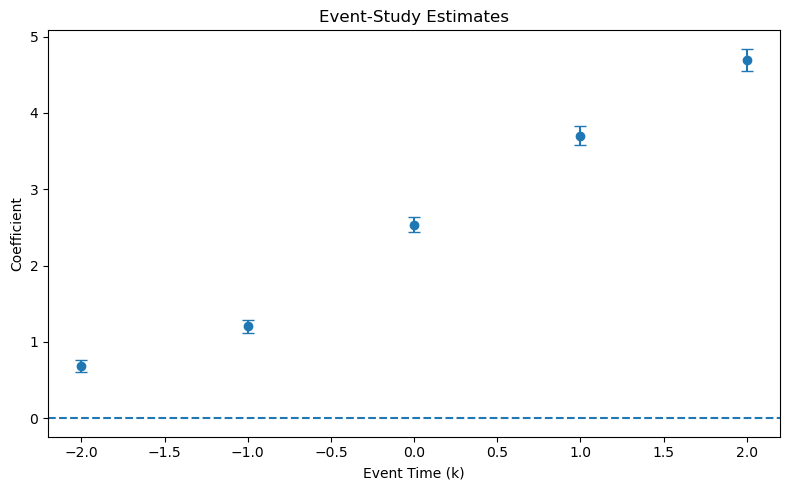

In [89]:
# ---- RECREATE coefficients DataFrame ----
event_vars = ["D_m2", "D_m1", "D_0", "D_1", "D_2"]

rows = []
for var in event_vars:
    coef = model_eventstudy.params[var]
    se   = model_eventstudy.bse[var]
    pval = model_eventstudy.pvalues[var]

    rows.append([
        var,
        coef,
        se,
        pval
    ])

coefficients = pd.DataFrame(rows, columns=["Variable", "Coef", "Std Error", "p-value"])

# ---- CLEAN FOR PLOTTING ----
def parse_k(label):
    if "m" in label:
        return -int(label.split("m")[1])
    return int(label.split("_")[1])

coef_data = coefficients.copy()
coef_data["k"] = coef_data["Variable"].apply(parse_k)
coef_data = coef_data.sort_values("k")

# ---- PLOT ----
plt.figure(figsize=(8,5))

plt.errorbar(
    coef_data["k"],
    coef_data["Coef"],
    yerr=coef_data["Std Error"],
    fmt='o',
    capsize=4
)

plt.axhline(0, linestyle='--')
plt.xlabel("Event Time (k)")
plt.ylabel("Coefficient")
plt.title("Event-Study Estimates")
plt.tight_layout()

plt.show()

## (2) Callaway-Sant'anna

`ATTgt(...).fit()` computes **group-time average treatment effects** using the Callaway & Sant’Anna (2021) DiD estimator. This estimator handles **staggered treatment adoption**, where different units start treatment in different periods.

- **g** = treatment cohort (the first period when units become treated)
- **t** = period when the effect is evaluated
- **ATT(g,t)** = the average treatment effect for units treated in period **g**, measured in period **t**

Key points:
- If **t < g**, the effect should be **0** (pre-treatment).
- If **t ≥ g**, the estimator measures the causal effect relative to valid controls (never-treated or not-yet-treated).


In [71]:
example_attgt = ATTgt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla="Y~X",
    data=dta,
    clustervar="cluster"
).fit()
example_attgt.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2,2,0.9209,1,0.0629,0.7534,1.0884,*
1,2,3,1.9875,1,0.0616,1.8236,2.1514,*
2,2,4,2.9552,1,0.0680,2.7741,3.1363,*
3,3,2,-0.0433,0,0.0671,-0.2220,0.1354,
4,3,3,1.1080,1,0.0651,0.9348,1.2813,*
5,3,4,2.0590,1,0.0647,1.8869,2.2312,*
6,4,2,0.0023,0,0.0685,-0.1800,0.1847,
7,4,3,0.0615,0,0.0636,-0.1079,0.2309,
8,4,4,0.9523,1,0.0681,0.7710,1.1337,*


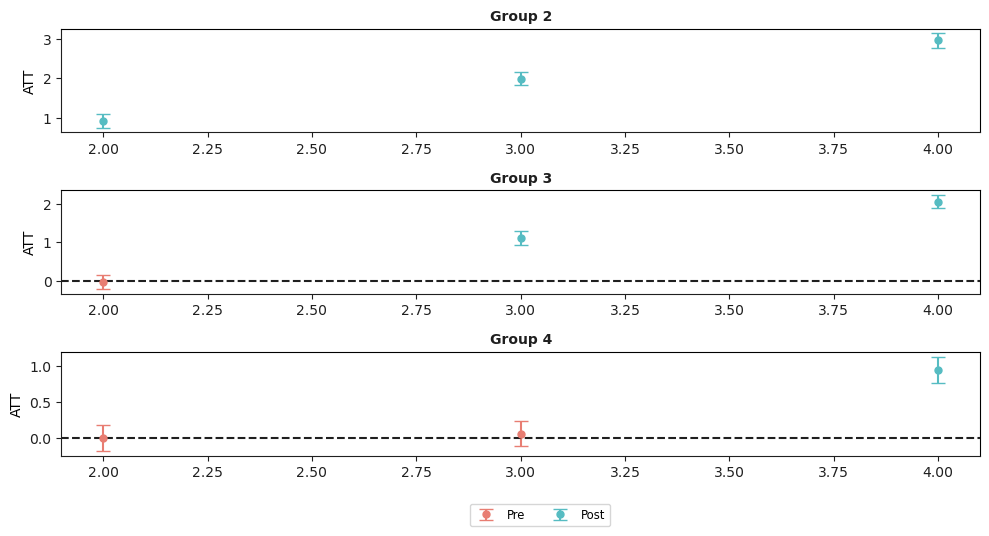

In [78]:
example_attgt.plot_attgt();

With all these $g \times t$ ATT's we can do the following aggregations:
1. A simple average for $ATT(g,t)$ whenever $g>=t$
2. Average weighted by **group**
3. Average for each **period** (calendar)
4. Average by 'relative time', i.e. **Event time** (dynamic)

In [79]:
example_attgt.aggte("simple")



   ATT Std. Error [95.0%  Conf. Int.]  
1.6583     0.0353 1.5892       1.7275 *


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust






Overall summary of ATT's based on group/cohort aggregation:
  ATT Std. Error [95.0%  Conf. Int.]  
1.488     0.0343 1.4208       1.5553 *


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0      2    1.9545      0.0524           1.8519      2.0572  *
1      3    1.5835      0.0553           1.4751      1.6920  *
2      4    0.9523      0.0675           0.8201      1.0845  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




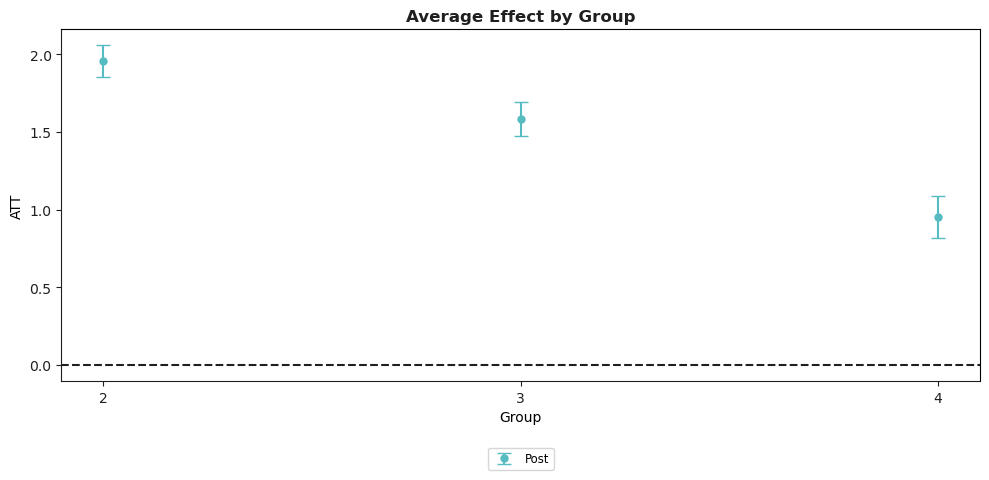

In [81]:
example_attgt.aggte("group")
example_attgt.plot_aggte();



Overall summary of ATT's based on calendar time aggregation:
   ATT Std. Error [95.0%  Conf. Int.]  
1.4808     0.0368 1.4087       1.5529 *


Time Effects (calendar):
   Time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0     2    0.9209      0.0639           0.7957      1.0461  *
1     3    1.5491      0.0524           1.4464      1.6518  *
2     4    1.9724      0.0490           1.8763      2.0684  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




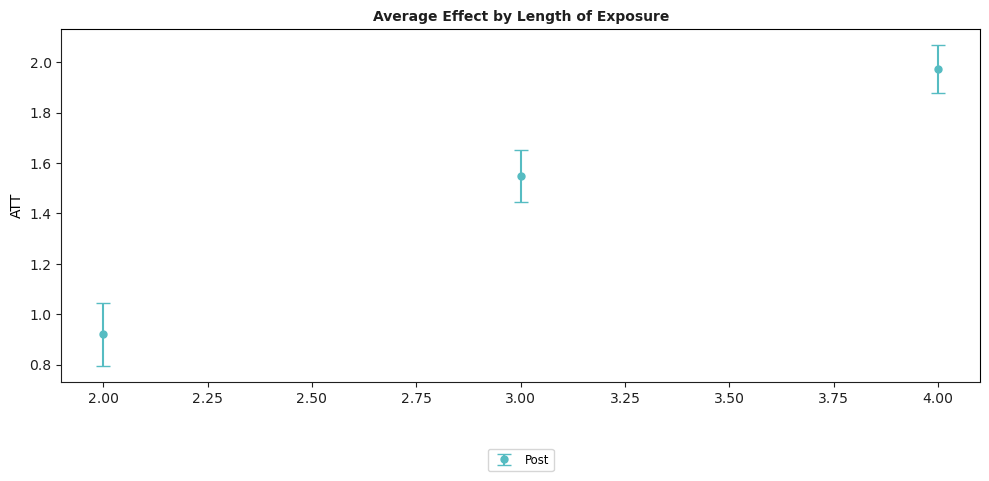

In [83]:
example_attgt.aggte("calendar")
example_attgt.plot_aggte();



Overall summary of ATT's based on event-study/dynamic aggregation:
   ATT Std. Error [95.0%  Conf. Int.]  
1.9904     0.0401 1.9119        2.069 *


Dynamic Effects:
   Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0          -2    0.0023      0.0641          -0.1233      0.1279   
1          -1    0.0105      0.0401          -0.0682      0.0892   
2           0    0.9929      0.0327           0.9288      1.0569  *
3           1    2.0231      0.0469           1.9311      2.1151  *
4           2    2.9552      0.0614           2.8349      3.0755  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  Never Treated , 
Anticipation Periods:  0
Estimation Method:  Doubly Robust




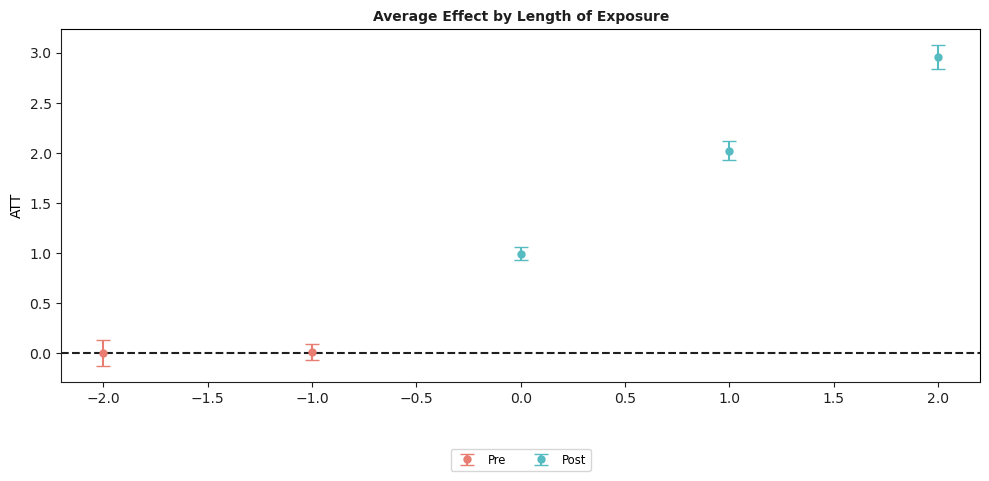

In [85]:
example_attgt.aggte("dynamic")
example_attgt.plot_aggte();

## Not yet treated units as controls

Estimates above used **Never-treated** units as the only control. We can estimate using units that haven't been treated yet as controls (use them for counterfactual).  

In [99]:
example_attgt_altcontrol = ATTgt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla="Y~X",
    data=dta,
    control_group="notyettreated",
    clustervar="cluster"
).fit()
example_attgt_altcontrol.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2,2,0.9371,1,0.0504,0.7974,1.0767,*
1,2,3,1.9612,1,0.0539,1.8119,2.1106,*
2,2,4,2.9552,1,0.0649,2.7753,3.1352,*
3,3,2,-0.0393,0,0.0597,-0.2048,0.1263,
4,3,3,1.0747,1,0.0540,0.9250,1.2244,*
5,3,4,2.0590,1,0.0650,1.8788,2.2392,*
6,4,2,0.0207,0,0.0629,-0.1538,0.1953,
7,4,3,0.0615,0,0.0699,-0.1324,0.2555,
8,4,4,0.9523,1,0.0631,0.7772,1.1274,*


In [96]:
example_attgt.summ_attgt().summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2,2,0.9209,1,0.0629,0.7534,1.0884,*
1,2,3,1.9875,1,0.0616,1.8236,2.1514,*
2,2,4,2.9552,1,0.0680,2.7741,3.1363,*
3,3,2,-0.0433,0,0.0671,-0.2220,0.1354,
4,3,3,1.1080,1,0.0651,0.9348,1.2813,*
5,3,4,2.0590,1,0.0647,1.8869,2.2312,*
6,4,2,0.0023,0,0.0685,-0.1800,0.1847,
7,4,3,0.0615,0,0.0636,-0.1079,0.2309,
8,4,4,0.9523,1,0.0681,0.7710,1.1337,*


Why are point estimates different except for $ATT(4,3)$ and $ATT(4,4)$?